In [3]:
# import required libraries
import matplotlib.pyplot as plt
import pandas as pd
import re
import requests
import spacy

In [7]:
# load the natural language processing model
nlp = spacy.load('en_core_web_sm')
nlp.Defaults.stop_words |= {'I'}

In [8]:
# retrieve Project Gutenberg Federalist Papers
url = 'https://www.gutenberg.org/cache/epub/1404/pg1404.txt'
text = requests.get(url).text

# remove extra text at the beginning
cutoff = text.index('\nTHE FEDERALIST PAPERS')
text = text[cutoff:]

# remove extra text at the end
cutoff = text.index('*** END OF THE PROJECT GUTENBERG EBOOK THE FEDERALIST PAPERS ***')
text = text[:cutoff].strip()

# remove some problem characters from text
text = text.replace('â\x80\x99', '\'').replace('â\x80\x9c', '"').replace('â\x80\x9d', '""').replace('â\x80\x94', ' ')

# inspect result
print(text[:300])

THE FEDERALIST PAPERS

By Alexander Hamilton, John Jay, and James Madison




FEDERALIST No. 1

General Introduction

For the Independent Journal. Saturday, October 27, 1787


HAMILTON

To the People of the State of New York:

AFTER an unequivocal experience of the inefficacy of th


In [9]:
# data cleaning functions

## find the author index
def find_author_index(text, pattern = r"\bJAY.*\r|\bMADISON.*\r|\bHAMILTON.*\r"):
  """
  Finds the index of the first occurrence of an author name. This word should be the author follows the title.

  Args:
    text: The text to search.

  Returns:
    The index of the first occurrence, or -1 if not found.
  """
  match = re.search(pattern, text)
  if match:
    # return match.start()
    a_start = match.start()
    a_end = match.end()
    return a_start, a_end
  else:
    return -1

## find the author of each paper
def find_author(text):
  """
  Extracts the author name from a single Federalist Paper.

  Args:
    text: The text to search.

  Returns:
    The text of the author's name.
  """
  a_start, a_end = find_author_index(text)
  return text[a_start:a_end].strip()

def remove_nums_spaces(text):
  """
  Removes numbers and unnecessary whitespace from texts.

  Args:
    text: The text to remove numbers and whitespace from.

  Returns:
    The text without numbers or unnecessary whitespace.
  """
  ### Check if text is a string. If so replace unnecessary white space.
  if isinstance(text, str):
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\d+', '', text)
  return text

punc = ["“", "”", "¶", "§", ",", ")", "(", ";", "[", "]", ":", "’", "*", ".", "$", "#", "%", "!", "+", "○", "●", "☺"]
def lemmatize_text(text):
    """
    Lemmatizes text.

    Args:
    text: The text to lemmatize.

    Returns:
    The lemmatized text.
    """
    doc = nlp(text)
    lemmas = [token.lemma_.lower() for token in doc if token.lemma_.lower() not in nlp.Defaults.stop_words and token.is_alpha]
    return lemmas

def extract_named_entities(text):
  """
  Takes a spaCy document object and returns a list of named entities.

  Args:
      doc: The spaCy document object.

  Returns:
      A list of named entities.
  """
  doc = nlp(text)
  return [ent.text for ent in doc.ents]

In [10]:
# Break text into individual papers, paper numbers
paper_nos = []
papers = []
for i in range(1, 86):
    start = text.index(f'FEDERALIST No. {i}')
    pap_no_len = len(f'FEDERALIST No. {i}')
    if i == 85:
        end = len(text)
    else:
      end = text.index(f'FEDERALIST No. {i+1}')
    # get paper number
    paper_no = text[start:start+pap_no_len]
    paper_nos.append(paper_no)
    # get paper text
    paper = text[start:end]
    papers.append(paper)

# create dataframe of texts
federalist_df = pd.DataFrame({'Paper_No': paper_nos, 'Text': papers})

## remove "FEDERALIST No." from Paper_No
federalist_df['Paper_No'] = federalist_df['Paper_No'].str.replace('FEDERALIST No.', '').str.strip()

## create Author column
federalist_df['Author'] = federalist_df['Text'].apply(find_author)
federalist_df['Author'] = federalist_df['Author']

## remove paper number, title, date and author from text
for index, row in federalist_df.iterrows():
    cutoff = find_author_index(row['Text'], pattern=row['Author'])[1]
    federalist_df.loc[index, 'Text'] = row['Text'][cutoff:].strip()

## remove numbers and unnecessary spaces from text
federalist_df['Text'] = federalist_df['Text'].apply(remove_nums_spaces)

## reorder columns
federalist_df = federalist_df[['Paper_No', 'Author', 'Text']]

## author to title case
federalist_df['Author'] = federalist_df['Author'].str.title()

## lemmatize - this reduces the number of variants of a base word that we'll see in our results
federalist_df['Lemma'] = federalist_df['Text'].apply(lemmatize_text)

## get named entities
federalist_df['Named_Entities'] = federalist_df['Text'].apply(extract_named_entities)

## reset index
federalist_df = federalist_df.reset_index(drop=True)

# print dataframe
print(federalist_df.head())

del text

  Paper_No    Author                                               Text  \
0        1  Hamilton  To the People of the State of New York: AFTER ...   
1        2       Jay  To the People of the State of New York: WHEN t...   
2        3       Jay  To the People of the State of New York: IT IS ...   
3        4       Jay  To the People of the State of New York: MY LAS...   
4        5       Jay  To the People of the State of New York: QUEEN ...   

                                               Lemma  \
0  [people, state, new, york, unequivocal, experi...   
1  [people, state, new, york, people, america, re...   
2  [people, state, new, york, new, observation, p...   
3  [people, state, new, york, paper, assign, reas...   
4  [people, state, new, york, queen, anne, letter...   

                                      Named_Entities  
0  [Constitution, the United States of America, U...  
1  [America, America, one, one, one, America, Sta...  
2  [Americans, many years, America, one, first,

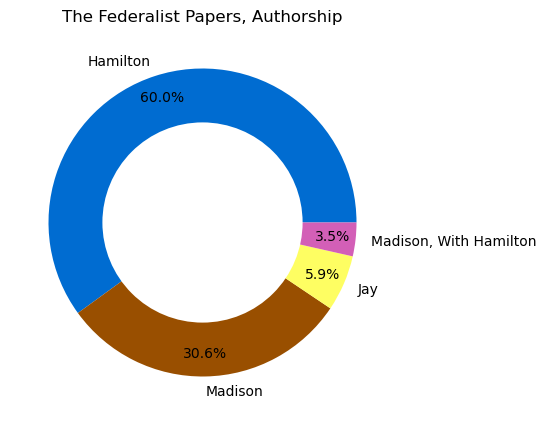

In [11]:
# make authorship donut chart
## create dataframe of authors, with count of rows for each author
authors_df = federalist_df[['Author']].value_counts().reset_index()

## make a list of unique authors for labels
Authors = authors_df['Author'].tolist()

## make list of counts
Counts = authors_df['count'].tolist()

## create colorblind friendly palette
Colors = ['#006CD1', '#994F00', '#FEFE62', '#D35FB7']

## create base figure
fig = plt.figure(figsize=(5,5))
plt.pie(Counts, labels=Authors, colors=Colors, autopct='%1.1f%%', pctdistance=0.85)

## create center circle
centre_circle = plt.Circle((0, 0), 0.65, fc='white')
fig = plt.gcf()

## add circle to figure
fig.gca().add_artist(centre_circle)
plt.title("The Federalist Papers, Authorship")
plt.show()

In [12]:
# get top 5 lemmas for each author
federalist_lemmas_df = federalist_df.drop(columns=['Text', 'Named_Entities'])
federalist_lemmas_df = federalist_lemmas_df.explode('Lemma').sort_values(by='Lemma')
federalist_lemmas_df.groupby('Author')['Lemma'].value_counts().groupby(level=0).head(5).to_frame().rename(columns={'Lemma': 'Count'}).reset_index()

,Author,Lemma,count
0,Hamilton,state,549
1,Hamilton,power,499
2,Hamilton,government,498
3,Hamilton,states,409
4,Hamilton,constitution,284
5,Jay,government,51
6,Jay,people,48
7,Jay,nation,40
8,Jay,treaty,33
9,Jay,national,31


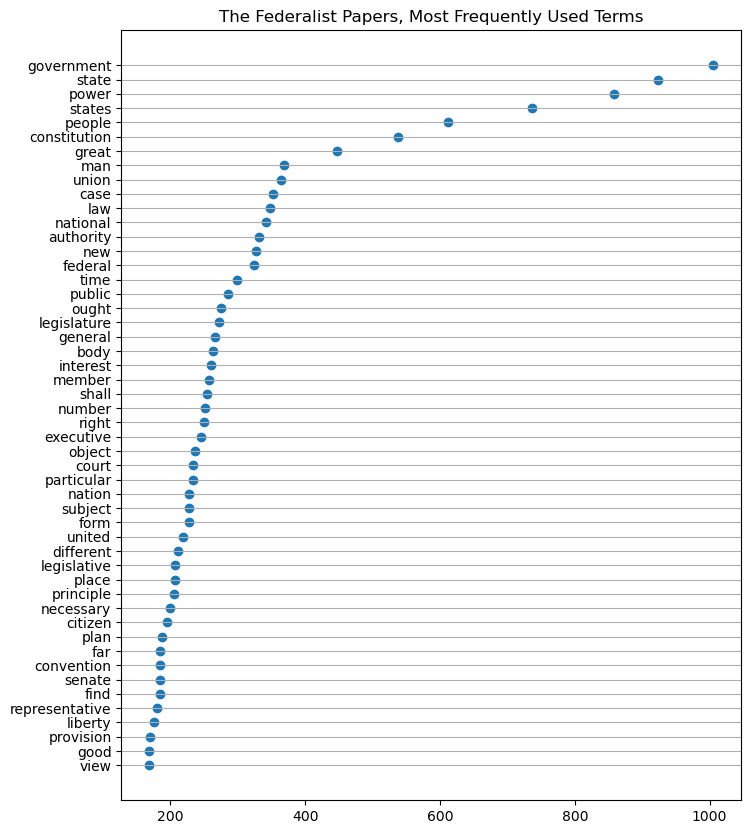

In [13]:
# plot top lemmas overall
## explode lemma, count
lemmas_df = federalist_df['Lemma'].explode().value_counts().reset_index()
lemmas_df.columns = ['Lemma', 'Count']

## create figure
fig = plt.figure(figsize=(8,10))

## Top 50 lemmas
lemmas_top = lemmas_df[:50]
lemmas_top = lemmas_top.sort_values(by ='Count',ascending=True)

## plot top 50 lemmas

plt.scatter(x=lemmas_top['Count'], y=lemmas_top.Lemma)
plt.title("The Federalist Papers, Most Frequently Used Terms")
plt.grid(axis='y')
plt.show()

In [14]:
# explode Named_Entities, count
entities_df = federalist_df['Named_Entities'].explode().value_counts().reset_index()
entities_df.columns = ['Entity', 'Count']

# examine result
entities_df.sort_values(by ='Count',ascending=False)

,Entity,Count
0,State,584
1,States,369
2,Constitution,310
3,one,259
4,first,199
...,...,...
466,IV,1
467,thirty years of age,1
468,twenty-five,1
469,more than,1


In [15]:
# clean up Entity; antiquated capitalization results in some junk
entities_df = entities_df[~entities_df['Entity'].isin(['American',
                                                       'annual',
                                                       'British',
                                                       'European',
                                                       'first',
                                                       'five',
                                                       'four',
                                                       'four years',
                                                       'fourth',
                                                       'one',
                                                       'One',
                                                       'one third',
                                                       'republican',
                                                       'second',
                                                       'secondly',
                                                       'senate',
                                                       'State',
                                                       'States',
                                                       'third',
                                                       'thirteen',
                                                       'three',
                                                       'two',
                                                       'Two',
                                                       'two thirds',
                                                       'two years'])].reset_index(drop=True)

# limit to top 30 most frequently mentioned entities
top_entities = entities_df[:30].sort_values(by ='Count',ascending=True)

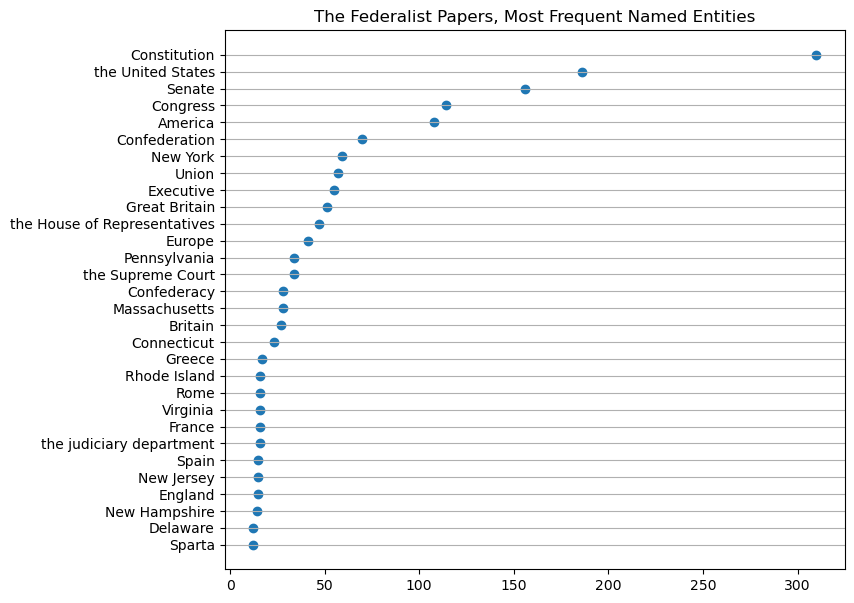

In [16]:
fig = plt.figure(figsize=(8,7))

# plot top 30 entities

plt.scatter(x=top_entities['Count'], y=top_entities.Entity)
plt.title("The Federalist Papers, Most Frequent Named Entities")
plt.grid(axis='y')
plt.show()